# Detecting Pixelation in Images
## Building a model from scratch

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import PIL

### Using data generated from PIXABAY

Generating High Resolution Images from Pixabay

In [ ]:
import requests
import os
from tqdm.notebook import tqdm

# Your Pixabay API Key
api_key = 'Your Api key'

# Directory to save the downloaded images
output_dir = 'path to output directory'
os.makedirs(output_dir, exist_ok=True)

# Parameters
num_images = 20  # Number of images to download
query = 'extinct species'  # Search query

# Pixabay API endpoint
url = f'https://pixabay.com/api/?key={api_key}&q={query}&image_type=photo&per_page={num_images}'

# Fetch images
response = requests.get(url).json()

# Download images
for i, image_info in enumerate(tqdm(response['hits'])):
    image_url = image_info['largeImageURL']
    image_data = requests.get(image_url).content
    with open(os.path.join(output_dir, f'image_{i+1}.jpg'), 'wb') as handler:
        handler.write(image_data)

print("Download complete.")


Generating 1920x1080 resolution images using Lanczos Resampling Method

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def upscale_to_1920x1080(image):
    # Get the current dimensions of the image
    height, width = image.shape[:2]
    
    # Calculate the scaling factor to fit within 1920x1080 while maintaining aspect ratio
    scale_x = 1920 / width
    scale_y = 1080 / height
    scale = min(scale_x, scale_y)
    
    # Resize the image using Lanczos resampling
    resized = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LANCZOS4)
    
    # Create a 1920x1080 black canvas
    canvas = np.zeros((1080, 1920, 3), dtype=np.uint8)
    
    # Calculate position to paste the resized image
    y_offset = (1080 - resized.shape[0]) // 2
    x_offset = (1920 - resized.shape[1]) // 2
    
    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset+resized.shape[0], x_offset:x_offset+resized.shape[1]] = resized
    
    return canvas

# Set your input and output directories
input_dir = 'Path to input directory'
output_dir = 'Path to output directory'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get list of image files
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Process each image
for filename in tqdm(image_files, desc="Processing images"):
    # Read the image
    img_path = os.path.join(input_dir, filename)
    img = cv2.imread(img_path)
    
    if img is None:
        print(f"Error reading {filename}. Skipping...")
        continue
    
    # Upscale the image
    upscaled = upscale_to_1920x1080(img)
    
    # Save the upscaled image
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, upscaled)

print("All images processed!")

Creating pixelated images 

In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path
from tqdm.notebook import tqdm
import random
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

def block_averaging(image, block_size):
    h, w = image.shape[:2]
    new_h, new_w = h // block_size, w // block_size
    return cv2.resize(cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA),
                      (w, h), interpolation=cv2.INTER_NEAREST)

def jpeg_compression(image, quality):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', image, encode_param)
    return cv2.imdecode(encimg, 1)

def mosaic_effect(image, block_size):
    h, w = image.shape[:2]
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            roi = image[y:y+block_size, x:x+block_size]
            color = roi.mean(axis=(0,1))
            image[y:y+block_size, x:x+block_size] = color
    return image

def apply_pixelation(image):
    technique = random.choice(['block', 'jpeg', 'mosaic'])
    if technique == 'block':
        return block_averaging(image, random.choice([16, 32, 64]))  # Increased block sizes
    elif technique == 'jpeg':
        return jpeg_compression(image, random.randint(1, 10))  # Further lowered quality range
    elif technique == 'mosaic':
        return mosaic_effect(image, random.choice([64, 128, 256]))  # Increased block sizes

def process_images(input_folder, output_folder, pixelation_ratio=0.6):
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    pixelated_path = output_path / 'pixelated'
    original_path = output_path / 'original'
    pixelated_path.mkdir(parents=True, exist_ok=True)
    original_path.mkdir(parents=True, exist_ok=True)

    image_files = list(input_path.glob('*'))
    random.shuffle(image_files)

    num_pixelated = int(len(image_files) * pixelation_ratio)
    
    for i, img_path in tqdm(enumerate(image_files), total=len(image_files)):
        if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
            img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
            
            if img is None:
                continue

            is_grayscale = len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1)

            if i < num_pixelated:
                if is_grayscale:
                    pixelated = apply_pixelation(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR))
                    pixelated = cv2.cvtColor(pixelated, cv2.COLOR_BGR2GRAY)
                else:
                    pixelated = apply_pixelation(img)
                
                output_file = pixelated_path / f"pixelated_{img_path.name}"
                cv2.imwrite(str(output_file), pixelated)
            else:
                output_file = original_path / img_path.name
                shutil.copy(str(img_path), str(output_file))

    print(f"Processed {len(image_files)} images.")
    print(f"Pixelated images: {num_pixelated}")
    print(f"Original images: {len(image_files) - num_pixelated}")

def display_sample_images(input_folder, num_samples=5):
    input_path = Path(input_folder)
    image_files = list(input_path.glob('*'))
    samples = random.sample(image_files, min(num_samples, len(image_files)))
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    for i, img_path in enumerate(samples):
        img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pixelated = apply_pixelation(img)
        pixelated_rgb = cv2.cvtColor(pixelated, cv2.COLOR_BGR2RGB)
        
        axes[i, 0].imshow(img_rgb)
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(pixelated_rgb)
        axes[i, 1].set_title('Pixelated')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Interactive cell for setting paths and parameters
input_folder = 'Path to input directory'  # Update this path
output_folder = 'Path to output directory'  # Update this path
pixelation_ratio = 0.6  # Adjust if needed

# Display sample pixelations
print("Displaying sample pixelations...")
display_sample_images(input_folder)

# Process images
print("Processing images...")
process_images(input_folder, output_folder, pixelation_ratio)

# Display results
print("\nDataset preparation complete!")
print(f"Pixelated images saved in: {output_folder}/pixelated")
print(f"Original images saved in: {output_folder}/original")

In [6]:
#Training Data
ds_train=tf.keras.preprocessing.image_dataset_from_directory(
    'E:/IMAG/aug_data_pix',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=2,
    image_size=(1080,1920),
    shuffle=True,
    seed=42,
    validation_split=0.1,
    subset='training'
)

Found 10000 files belonging to 2 classes.
Using 9000 files for training.


In [7]:
#Validation Data
ds_val=tf.keras.preprocessing.image_dataset_from_directory(
    'E:/IMAG/aug_data_pix',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=2,
    image_size=(1080,1920),
    shuffle=True,
    seed=42,
    validation_split=0.1,
    subset='validation'
)

Found 10000 files belonging to 2 classes.
Using 1000 files for validation.


### Normalizing the Data

In [8]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

ds_train = ds_train.map(process)
ds_val=ds_val.map(process)

All the pixel values are noew between 0-1

### Building a Model with architecture similar to VGG16
Number of neurons is less in the Dense layers so as to reduce the computation

In [10]:
model2=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
   tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
   tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2),
    tf.keras.layers.MaxPool2D(strides=2),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4,activation='relu'),
     tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])

### Input size is Full HD (1920 x 1080)

In [11]:
model2.build((None,1080,1920,3))
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 1078, 1918, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1076, 1916, 32) │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 538, 958, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 538, 958, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 536, 956, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 534, 954, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 267, 477, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 267, 477, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 265, 475, 256)  │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 263, 473, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 131, 236, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 131, 236, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 129, 234, 512)  │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 127, 232, 512)  │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 116, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 58, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 31, 58, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 920576)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │    14,729,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             

 Total params: 19,067,597 (72.74 MB)

 Trainable params: 19,067,597 (72.74 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    #min_delta=0.01,
    patience=2,
    mode='auto',
    verbose=2,
    baseline=None
)
# Monitoring Validation Loss
#Even though not required when epochs are low, it is done just in case

In [15]:
model2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
              metrics=["accuracy"])

In [16]:
model2.fit(ds_train,epochs=5,validation_data=ds_val,batch_size=1,callbacks=[callback])

Epoch 1/5
   1/4500 ━━━━━━━━━━━━━━━━━━━━ 23:28:13 19s/step - accuracy: 1.0000 - loss: 0.6858

KeyboardInterrupt: 

As seen above, the time to complete a single epoch is >23hrs initially, this model is not practical to train

##### We build another model, which is less computationally heavy

In [17]:
model3=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=8,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.Conv2D(filters=8,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2),
    tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2),
    #tf.keras.layers.MaxPool2D(strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(4,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model3.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])
model3.build((None,1080,1920,3))
model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 1078, 1918, 8)  │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 1076, 1916, 8)  │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 538, 958, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 536, 956, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 534, 954, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 267, 477, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 265, 475, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 263, 473, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 131, 236, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 129, 234, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 127, 232, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 116, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 61, 114, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 59, 112, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 29, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 207872)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     6,651,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,947,585 (26.50 MB)

 Trainable params: 6,947,585 (26.50 MB)

 Non-trainable params: 0 (0.00 B)

history = model3.fit(ds_train,validation_data=ds_val,epochs=10,batch_size=2,callbacks=[callback])
Epoch 1/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1159s 257ms/step - accuracy: 0.5950 - loss: 0.7279 - val_accuracy: 0.6220 - val_loss: 0.6647
Epoch 2/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1126s 250ms/step - accuracy: 0.5993 - loss: 0.6735 - val_accuracy: 0.6220 - val_loss: 0.6642
Epoch 3/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1133s 252ms/step - accuracy: 0.5992 - loss: 0.6734 - val_accuracy: 0.6220 - val_loss: 0.6642
Epoch 4/10
3215/4500 ━━━━━━━━━━━━━━━━━━━━ 5:17 247ms/step - accuracy: 0.6004 - loss: 0.6729

As you can see, the Validation Loss stagnates and the model will tend to overfit later.
This model was run for 20 epochs prior to the current training but resulted in overfitting.

 Another model which also follows the given constraint( < 10MB) was built

In [18]:
model4=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model4.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=['Accuracy'])
model4.build((None,1080,1920,3))
model4.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 1078, 1918, 16) │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 539, 959, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 537, 957, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 268, 478, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 266, 476, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 133, 238, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 131, 236, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 65, 118, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 63, 116, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 31, 58, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 29, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 12, 26, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 4, 11, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       327,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,494,817 (9.52 MB)

 Trainable params: 2,494,817 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

The accuracy in this model stagnated to around 0.6722 for more than 10 epochs of training. Hence even this was Discarded.

### Using a pretrained Model

Given all the challenges and the time constraint, a pretrained model was taken into consideration
The model used : YOLOv8n-cls

In [20]:
!pip install ultralytics

     ---------------------------------------- 0.0/41.2 kB ? eta -:--:--
     ------------------ ------------------- 20.5/41.2 kB 682.7 kB/s eta 0:00:01
     -------------------------------------- 41.2/41.2 kB 659.1 kB/s eta 0:00:00
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached ultralytics_thop-2.0.0-py3-none-any.whl.metadata (8.5 kB)
   ---------------------------------------- 0.0/801.6 kB ? eta -:--:--
   ----------- ---------------------------- 225.3/801.6 kB 6.9 MB/s eta 0:00:01
   ---------------------------- ----------- 573.4/801.6 kB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 801.6/801.6 kB 6.3 MB/s eta 0:00:00
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached ultralytics_thop-2.0.0-py3-none-any.whl (25 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)


In [22]:
from ultralytics import YOLO

In [23]:
model=YOLO("yolov8n-cls.pt")

C:\Users\user\anaconda3\envs\test\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [25]:
results=model.train(data="E:/hmm/pix_e/", epochs=10, imgsz=512)

Ultralytics YOLOv8.2.57  Python-3.11.9 torch-2.3.0 CPU (12th Gen Intel Core(TM) i9-12900K)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=E:/hmm/pix_e/, epochs=10, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning E:\hmm\pix_e\train... 2375 images, 0 corrupt: 100%|██████████| 2375/2375 [00:01<00:00, 1369.11it/s]


train: New cache created: E:\hmm\pix_e\train.cache


val: Scanning E:\hmm\pix_e\test... 400 images, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 


optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs\classify\train6
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:54<00:00,  4.23s/it]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:57<00:00,  4.44s/it]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:56<00:00,  4.35s/it]

                   all      0.877          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:57<00:00,  4.45s/it]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:50<00:00,  3.92s/it]

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:52<00:00,  4.00s/it]

                   all      0.868          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:50<00:00,  3.85s/it]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:51<00:00,  3.99s/it]

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:55<00:00,  4.23s/it]

                   all      0.925          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10         0G     0.2145          7        512: 100%|██████████| 149/149 [12:34<00:00,  5.06s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:54<00:00,  4.19s/it]

                   all       0.89          1



10 epochs completed in 2.348 hours.
Optimizer stripped from runs\classify\train6\weights\last.pt, 3.0MB
Optimizer stripped from runs\classify\train6\weights\best.pt, 3.0MB

Validating runs\classify\train6\weights\best.pt...
Ultralytics YOLOv8.2.57  Python-3.11.9 torch-2.3.0 CPU (12th Gen Intel Core(TM) i9-12900K)
YOLOv8n-cls summary (fused): 73 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
WARNING  Dataset 'split=val' not found, using 'split=test' instead.
train: E:\hmm\pix_e\train... found 2375 images in 2 classes  
val: None...
test: E:\hmm\pix_e\test... found 400 images in 2 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:48<00:00,  3.76s/it]


                   all      0.978          1
Speed: 0.0ms preprocess, 85.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train6
Results saved to runs\classify\train6


In [42]:
print(results.results_dict)

{'metrics/accuracy_top1': 0.9775000214576721, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9887500107288361}


In [43]:
cm=results.confusion_matrix
cm.plot(save_dir='E:/hmm')

In [45]:
cm.tp_fp()

(array([        196,         195]), array([          5,           4]))

In [37]:
res=model.predict("E:/hmm/pix_e/test/pixelated",imgsz=1088)
res.count()


image 1/200 E:\hmm\pix_e\test\pixelated\pixelated_image_1005.jpg: 512x512 pixelated 1.00, original 0.00, 43.2ms
image 2/200 E:\hmm\pix_e\test\pixelated\pixelated_image_1043.jpg: 512x512 pixelated 0.82, original 0.18, 83.5ms
image 3/200 E:\hmm\pix_e\test\pixelated\pixelated_image_1086.jpg: 512x512 original 0.52, pixelated 0.48, 80.5ms
image 4/200 E:\hmm\pix_e\test\pixelated\pixelated_image_1150.jpg: 512x512 pixelated 1.00, original 0.00, 81.9ms
image 5/200 E:\hmm\pix_e\test\pixelated\pixelated_image_1175.jpg: 512x512 pixelated 1.00, original 0.00, 80.7ms
image 6/200 E:\hmm\pix_e\test\pixelated\pixelated_image_124.jpg: 512x512 pixelated 0.99, original 0.01, 83.6ms
image 7/200 E:\hmm\pix_e\test\pixelated\pixelated_image_1242.jpg: 512x512 pixelated 1.00, original 0.00, 92.5ms
image 8/200 E:\hmm\pix_e\test\pixelated\pixelated_image_1252.jpg: 512x512 pixelated 1.00, original 0.00, 81.1ms
image 9/200 E:\hmm\pix_e\test\pixelated\pixelated_image_1328.jpg: 512x512 pixelated 1.00, original 0.00,

TypeError: list.count() takes exactly one argument (0 given)

In [41]:
for i in range(200):
    res[i].save_txt('E:/hmm/result/res.txt')

In [ ]:
results.results_dict

{'metrics/accuracy_top1': 0.9950000047683716,
 'metrics/accuracy_top5': 1.0,
 'fitness': 0.9975000023841858}

In [52]:
from matplotlib.pyplot import figure

figure(figsize=(16, 16), dpi=80)

<Figure size 1280x1280 with 0 Axes>

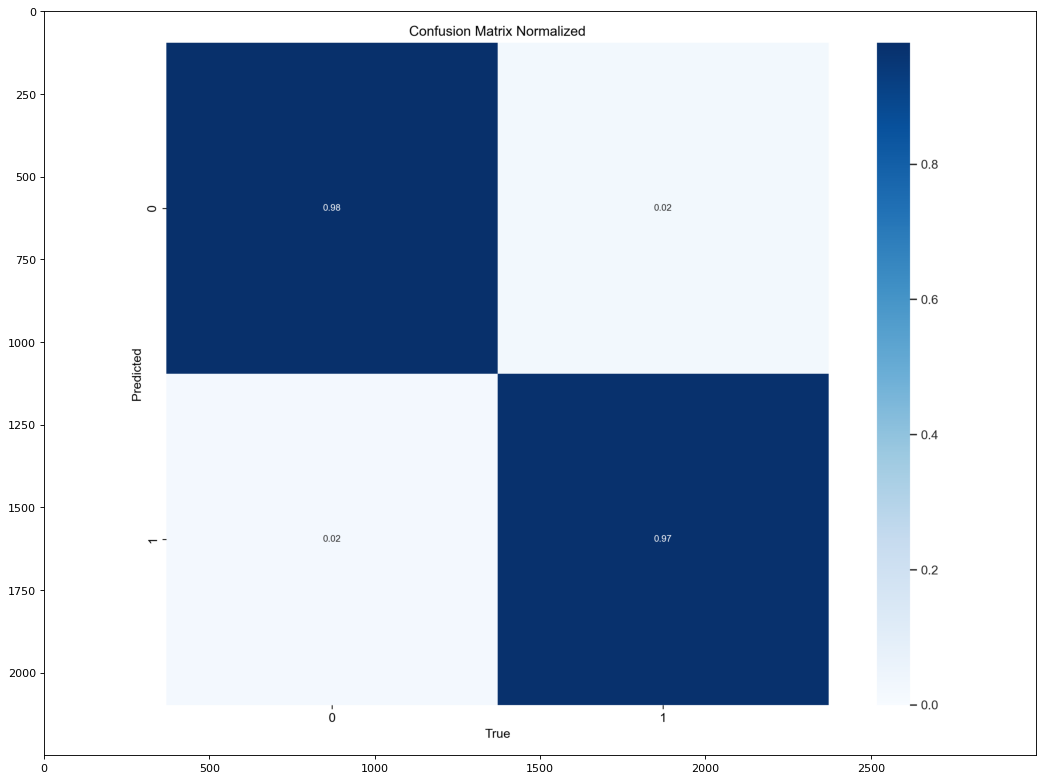

In [53]:
%matplotlib inline
img=PIL.Image.open('E:/hmm/confusion_matrix_normalized.png')
plt.imshow(img)
plt.show()

We can see that the TP=0.98 and FP=0.02. While TN=0.97 and FN=0.02

Precision = 0.98
Recall = 0.98
F1 score= 0.98

## Reconstruction of a pixelated Image

#### Using the pretrained Super Resolution Convolutional Neural Network (SRCNN)

In [ ]:
import sys
import keras
import cv2
import numpy as np
import matplotlib
import skimage
import PIL
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import numpy as np
import math
import os

%matplotlib inline

#### Functions to calculate metrics like MSE and PSNR

In [55]:
def psnr(target,ref):
    target_data=target.astype(float)
    ref_data=ref.astype(float)
    
    diff=ref_data-target_data
    diff=diff.flatten('C')
    
    rmse=math.sqrt(np.mean(diff**2.))
    
    return 20*math.log10(255./rmse)


def mse(target,ref):
    
    err=np.sum((target.astype('float')-ref.astype('float'))**2)
    err=err/float(target.shape[0]*target.shape[1])
    
    return err

def compare_images(target,ref):
    scores=[]
    scores.append(psnr(target,ref))
    scores.append(mse(target,ref))
    
    return scores

#### Creating a model with the architecture compatible with the weights

In [ ]:
def model():
    
    # define model type
    SRCNN = Sequential()
    
    #add model layers;filters =no. of nodes in the layer
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))#only if in keras.json image_data_format is channels_last; else if channels_first then 1,None,None
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    #input_shape takes image of any height and width as long it is one channel
    #that is how the SRCNN handles input,it handles image slice inputs, it doesn't work at all 3 channels at once
    #SRCNN was trained on the luminescence channel in the YCrCb color space 
    
    # define optimizer
    adam = Adam(learning_rate=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

Loading Weights

In [ ]:
srcnn=model()
srcnn.load_weights(r"C:\Users\user\Downloads\3051crop_weight_200.h5")
srcnn.summary()

Model: "sequential_7"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, None, None,     │        10,496 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, None, None, 64) │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, None, None, 1)  │         1,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 85,889 (335.50 KB)
 Trainable params: 85,889 (335.50 KB)
 Non-trainable params: 0 (0.00 B)

Helper Functions to prevent Shape mismatch during processing

In [ ]:
def modcrop(img,scale):
    #temp size
    tmpsz=img.shape
    sz=tmpsz[0:2]
    
    #ensures that dimension of our image are divisible by scale(doesn't leaves hanging remainders) by cropping the images size
    #np.mod returns the remainder bewtween our sz and scale
    sz=sz-np.mod(sz,scale)
    
    img=img[0:sz[0],1:sz[1]]
    return img

def shave(image,border):
    img=image[border: -border,border:-border]
    return img

In [ ]:
degraded=cv2.imread(r"E:\IMAG\noise_dir\noise\noisy_image_10.jpg")
ref=cv2.imread(r"E:\IMAG\test_pix\original\image_10.jpg")

In [ ]:
ref=modcrop(ref,3)
temp=cv2.cvtColor(degraded,cv2.COLOR_BGR2YCrCb)
Y=numpy.zeros((1,temp.shape[0],temp.shape[1],1),dtype=float)
Y[0,:,:,0]=temp[:,:,0].astype(float)/255
pre=srcnn.predict(Y,batch_size=1) #Input for the model
pre*=255
pre[pre[:]>255]=255
pre[pre[:]<0] =0
pre=pre.astype(np.uint8)
temp=shave(temp,6)
temp[:,:,0]=pre[0,:,:,0]
output=cv2.cvtColor(temp,cv2.COLOR_YCrCb2BGR)
ref = shave(ref.astype(np.uint8), 6)
degraded = shave(degraded.astype(np.uint8), 6)
scores = []
scores.append(compare_images(degraded, ref))#degraded wrt ref
scores.append(compare_images(output, ref))

In [ ]:
print('Degraded Image: \nPSNR: {}\nMSE: {}'.format(scores[0][0], scores[0][1]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}'.format(scores[1][0], scores[1][1]))

Degraded Image: 
PSNR: 21.66881373637018
MSE: 1328.3736185824353
Reconstructed Image: 
PSNR: 21.340177530206503
MSE: 1432.7943575708655

As you can see, the model performs very poorly, so much so that the reconstructed image has lesser PSNR and MSE values

### Hence we decided to use another model : MIRnetv2 to help reconstruct the input image

### Initial Set Up

In [ ]:
!git clone https://github.com/swz30/MIRNetv2.git

In [ ]:
!cd MIRNetv2

In [ ]:
!conda install pytorch=1.11 torchvision cudatoolkit=10.2 -c pytorch
!pip install matplotlib scikit-learn scikit-image opencv-python yacs joblib natsort h5py tqdm
!pip install einops gdown addict future lmdb numpy pyyaml requests scipy tb-nightly yapf lpips

In [ ]:
!python setup.py develop --no_cuda_ext

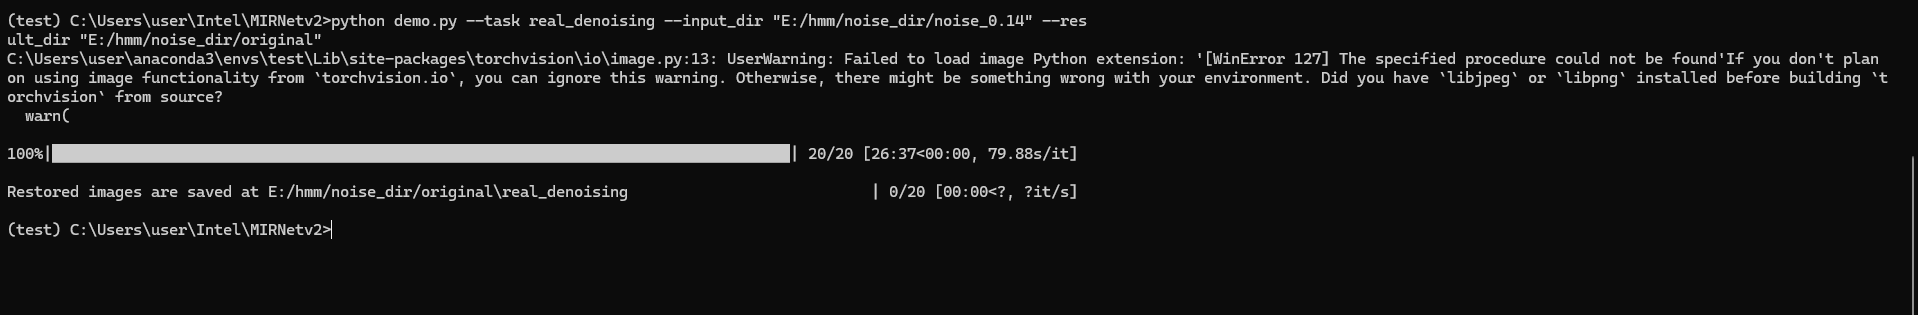

In [59]:
import os
import numpy as np
from skimage import io
from skimage.metrics import peak_signal_noise_ratio

def calculate_psnr(original_dir, pixelated_dir, output_dir):
    psnr_results = []

    for filename in os.listdir(original_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            base_name = os.path.splitext(filename)[0]
            original = io.imread(os.path.join(original_dir, filename))
            pixelated = io.imread(os.path.join(pixelated_dir, filename))
            output_filename = f"{base_name}.png"
            output_path = os.path.join(output_dir, output_filename)
            if not os.path.exists(output_path):
                print(f"Warning: Output file {output_filename} not found. Skipping.")
                continue
            
            output = io.imread(output_path)

            if original.shape != pixelated.shape or original.shape != output.shape:
                print(f"Warning: Image shapes don't match for {filename}. Skipping.")
                continue

            psnr_pixelated = peak_signal_noise_ratio(original, pixelated)
            psnr_output = peak_signal_noise_ratio(original, output)

            psnr_results.append({
                'filename': filename,
                'psnr_pixelated': psnr_pixelated,
                'psnr_output': psnr_output
            })

    return psnr_results

original_dir = "E:/hmm/noise_dir/original"
pixelated_dir = "E:/hmm/noise_dir/noise_0.14"
output_dir = "E:/hmm/noise_dir/real_denoising"

results = calculate_psnr(original_dir, pixelated_dir, output_dir)

for result in results:
    print(f"File: {result['filename']}")
    print(f"PSNR (Original vs Pixelated): {result['psnr_pixelated']:.2f} dB")
    print(f"PSNR (Original vs Output): {result['psnr_output']:.2f} dB")
    print()

File: noisy_image_1.jpg
PSNR (Original vs Pixelated): 25.34 dB
PSNR (Original vs Output): 26.92 dB

File: noisy_image_10.jpg
PSNR (Original vs Pixelated): 25.30 dB
PSNR (Original vs Output): 28.07 dB

File: noisy_image_2.jpg
PSNR (Original vs Pixelated): 25.29 dB
PSNR (Original vs Output): 27.22 dB

File: noisy_image_3.jpg
PSNR (Original vs Pixelated): 25.19 dB
PSNR (Original vs Output): 26.24 dB

File: noisy_image_4.jpg
PSNR (Original vs Pixelated): 24.92 dB
PSNR (Original vs Output): 27.42 dB

File: noisy_image_5.jpg
PSNR (Original vs Pixelated): 24.87 dB
PSNR (Original vs Output): 22.47 dB

File: noisy_image_6.jpg
PSNR (Original vs Pixelated): 25.23 dB
PSNR (Original vs Output): 27.95 dB

File: noisy_image_7.jpg
PSNR (Original vs Pixelated): 25.44 dB
PSNR (Original vs Output): 29.49 dB

File: noisy_image_8.jpg
PSNR (Original vs Pixelated): 25.31 dB
PSNR (Original vs Output): 27.59 dB

File: noisy_image_9.jpg
PSNR (Original vs Pixelated): 25.41 dB
PSNR (Original vs Output): 27.18 dB


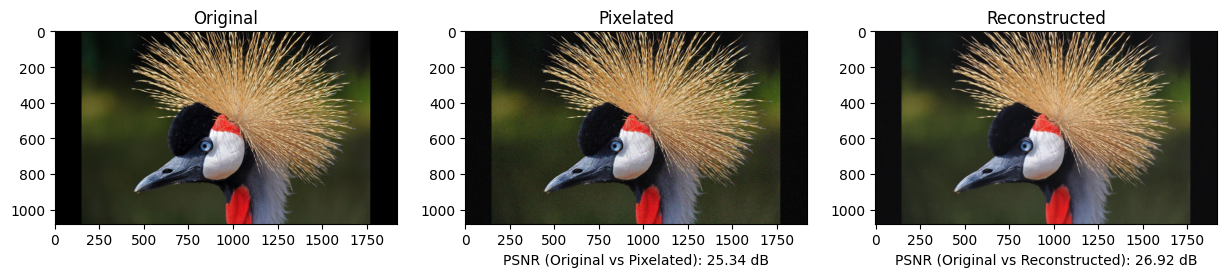

### After testing on few samples, we observe that there is an average increase of 2-3dB in PSNR value for each image.
